In [2]:
import matplotlib.pyplot as plt
import numpy as np
from rasterio import plot
import pandas as pd
import sys
import os
#import earthpy.plot as ep
import gdal
import shapefile


import fiona, rasterio
import geopandas as gpd
import rasterio.plot as rplt
from rasterio.features import rasterize
from rasterstats import zonal_stats

# import rasterio as rio
# from rasterio.plot import show
# from rasterio.mask import mask
# from shapely.geometry import mapping
# import geopandas as gpd
# import earthpy as et
# import earthpy.spatial as es

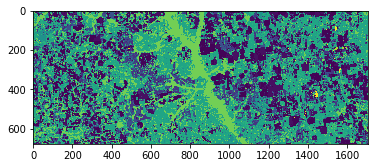

[  0   1   2   4   5  10  24  26  27  28  29  36  37  48  53  54  57  58
  59  61  69  74 111 121 122 123 124 131 141 142 143 152 176 190 195 209
 221 222 226 236 238 241]


In [9]:
data_folder_path = '/home/chris/Desktop/diploma/Diploma-Workspace/Data/'
labels_folder_path = '/home/chris/Desktop/diploma/Diploma-Workspace/Ground_Truth_Data/'
shapefiles_folder_path = data_folder_path + 'Shapefiles/'

tif_path = labels_folder_path + 'CDL.tif'

crop_data_tif = gdal.Open(tif_path)
crop_data = np.array(crop_data_tif.GetRasterBand(1).ReadAsArray())
plot.show(crop_data)
print(np.unique(crop_data))

In [11]:
shapefiles_name_list = os.listdir(data_folder_path + 'Shapefiles/')
shapefiles_name_list = [file for file in shapefiles_name_list if file.endswith('shp')]
print(shapefiles_name_list)

print(output_file)
print(tif_path)

['Corn_shapefile_64.shp', 'Cotton_shapefile_64.shp', 'Peanuts_shapefile_64.shp']
/home/chris/Desktop/diploma/Diploma-Workspace/Data/cotton_shapefile.shp
/home/chris/Desktop/diploma/Diploma-Workspace/Ground_Truth_Data/CDL.tif


In [13]:
shapefiles_list =[]
for sf in shapefiles_name_list:
    shapefiles_list.append(shapefile.Reader(shapefiles_folder_path + sf))
    
print(shapefiles_list)

[<shapefile.Reader object at 0x7fe04dd849b0>, <shapefile.Reader object at 0x7fe04dd844a8>, <shapefile.Reader object at 0x7fe04e82da20>]


In [16]:
shapes = shapefiles_list[2].shapes()
print(len(shapes))
print(['%.3f' % coord for coord in shapes[0].bbox])

for name in dir(shapes[0]):
    if not name.startswith('_'):
        print(name)
        
#shapeType: an integer representing the type of shape as defined by the shapefile specification
#shapeTypeName: a string representation of the type of shape as defined by shapeType. Read-only.
#bbox: If the shape type contains multiple points this tuple describes the lower left (x,y) coordinate and upper right corner coordinate creating a complete box around the points. If the shapeType is a Null (shapeType == 0) then an AttributeError is raised.
#parts: Parts simply group collections of points into shapes. If the shape record has multiple parts this attribute contains the index of the first point of each part. If there is only one part then a list containing 0 is returned.
#points: The points attribute contains a list of tuples containing an (x,y) coordinate for each point in the shape.

248
['1045305.000', '934485.000', '1045695.000', '934875.000']
bbox
parts
points
shapeType
shapeTypeName


In [17]:
# if you need to do more than just type or bounds checking,
#you may want to convert the geometry to the more human-readable
#GeoJSON format, where lines and polygons are grouped for you:
s = shapefiles_list[2].shape(0)
geoj = s.__geo_interface__
geoj['type']

'Polygon'

In [18]:
fields = shapefiles_list[2].fields
records = shapefiles_list[2].records()
dct = records[0].as_dict()

In [19]:
print(fields)
print(type(records[0][0]))
sorted(dct.items())
print(records[0].oid)

[('DeletionFlag', 'C', 1, 0), ['Area', 'N', 24, 15]]
<class 'float'>
0


In [9]:
import rasterstats as rs

In [10]:
stats = rs.zonal_stats(output_file, tif_path, stats=rs.utils.VALID_STATS, nodata=-9999)
summed_file_path = data_folder_path + 'summed_map_shapefile.shp'
summed_stats = rs.zonal_stats(summed_file_path, tif_path,  stats="count min mean max median", nodata=-9999)

In [11]:
print((stats))

[{'min': 1.0, 'max': 152.0, 'mean': 4.274760383386582, 'count': 939, 'sum': 4014.0, 'std': 13.938978217949666, 'median': 2.0, 'majority': 2.0, 'minority': 1.0, 'unique': 8, 'range': 151.0, 'nodata': 0.0, 'nan': 0}, {'min': 2.0, 'max': 2.0, 'mean': 2.0, 'count': 728, 'sum': 1456.0, 'std': 0.0, 'median': 2.0, 'majority': 2.0, 'minority': 2.0, 'unique': 1, 'range': 0.0, 'nodata': 0.0, 'nan': 0}, {'min': 2.0, 'max': 61.0, 'mean': 2.232894736842105, 'count': 760, 'sum': 1697.0, 'std': 3.6995336888904604, 'median': 2.0, 'majority': 2.0, 'minority': 61.0, 'unique': 2, 'range': 59.0, 'nodata': 0.0, 'nan': 0}, {'min': 2.0, 'max': 61.0, 'mean': 2.1338709677419354, 'count': 620, 'sum': 1323.0, 'std': 2.4302823112517062, 'median': 2.0, 'majority': 2.0, 'minority': 61.0, 'unique': 3, 'range': 59.0, 'nodata': 0.0, 'nan': 0}, {'min': 2.0, 'max': 190.0, 'mean': 7.159395973154362, 'count': 596, 'sum': 4267.0, 'std': 23.08518865432166, 'median': 2.0, 'majority': 2.0, 'minority': 123.0, 'unique': 10, 'ra

In [20]:
print((summed_stats))

[{'min': 2.0, 'max': 152.0, 'mean': 68.0909090909091, 'count': 11, 'median': 61.0}, {'min': 1.0, 'max': 241.0, 'mean': 1.5016077170418007, 'count': 622, 'median': 1.0}, {'min': 1.0, 'max': 152.0, 'mean': 4.274760383386582, 'count': 939, 'median': 2.0}, {'min': 2.0, 'max': 190.0, 'mean': 15.583606557377049, 'count': 610, 'median': 10.0}, {'min': 2.0, 'max': 10.0, 'mean': 9.933747412008282, 'count': 483, 'median': 10.0}, {'min': 121.0, 'max': 121.0, 'mean': 121.0, 'count': 1, 'median': 121.0}, {'min': 2.0, 'max': 2.0, 'mean': 2.0, 'count': 728, 'median': 2.0}, {'min': 2.0, 'max': 10.0, 'mean': 9.893967093235831, 'count': 547, 'median': 10.0}, {'min': 2.0, 'max': 61.0, 'mean': 2.232894736842105, 'count': 760, 'median': 2.0}, {'min': 10.0, 'max': 152.0, 'mean': 11.455344070278185, 'count': 683, 'median': 10.0}, {'min': 2.0, 'max': 10.0, 'mean': 9.97283531409168, 'count': 589, 'median': 10.0}, {'min': 2.0, 'max': 10.0, 'mean': 9.943253467843633, 'count': 793, 'median': 10.0}, {'min': 10.0, 

In [12]:
import csv
toCSV = summed_stats
keys = toCSV[0].keys()
# print(keys)
with open('summed_stats.csv', 'w') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(toCSV)

In [13]:
toCSV = stats
keys = toCSV[0].keys()
# print(keys)
with open('people.csv', 'w') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(toCSV)